In [1]:
import numpy as np

# data I/O
data = open('input.txt', 'r').read() # should be simple plain text file
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 1115393 characters, 65 unique.


In [2]:
# lets try write here the GRU version lol 
# hyperparameters
hidden_size = 512 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-2

In [3]:
# Model parameters initialization
def init_weight(*shape):
    fan_in = shape[1] if len(shape) > 1 else shape[0]
    return np.random.randn(*shape) * np.sqrt(2.0 / fan_in)  # He initialization

def triple():
    """
    Returns (Wx, Wh, b) each gate param
    hidden_size x vocab_size, hidden_size x hidden_size, hidden_size x 1
    """
    return (init_weight(hidden_size, vocab_size),  # input -> hidden
            init_weight(hidden_size, hidden_size), # hidden -> hidden
            np.zeros((hidden_size, 1)))            # bias

Wxz, Whz, bz = triple()  # Update gate
Wxr, Whr, br = triple()  # Reset gate
Wxh, Whh, bh = triple()  # Candidate hidden state

Why = init_weight(vocab_size, hidden_size)  # hidden -> output
by = np.zeros((vocab_size, 1))


![Screenshot 2025-01-21 at 23.28.39.png](<attachment:Screenshot 2025-01-21 at 23.28.39.png>)
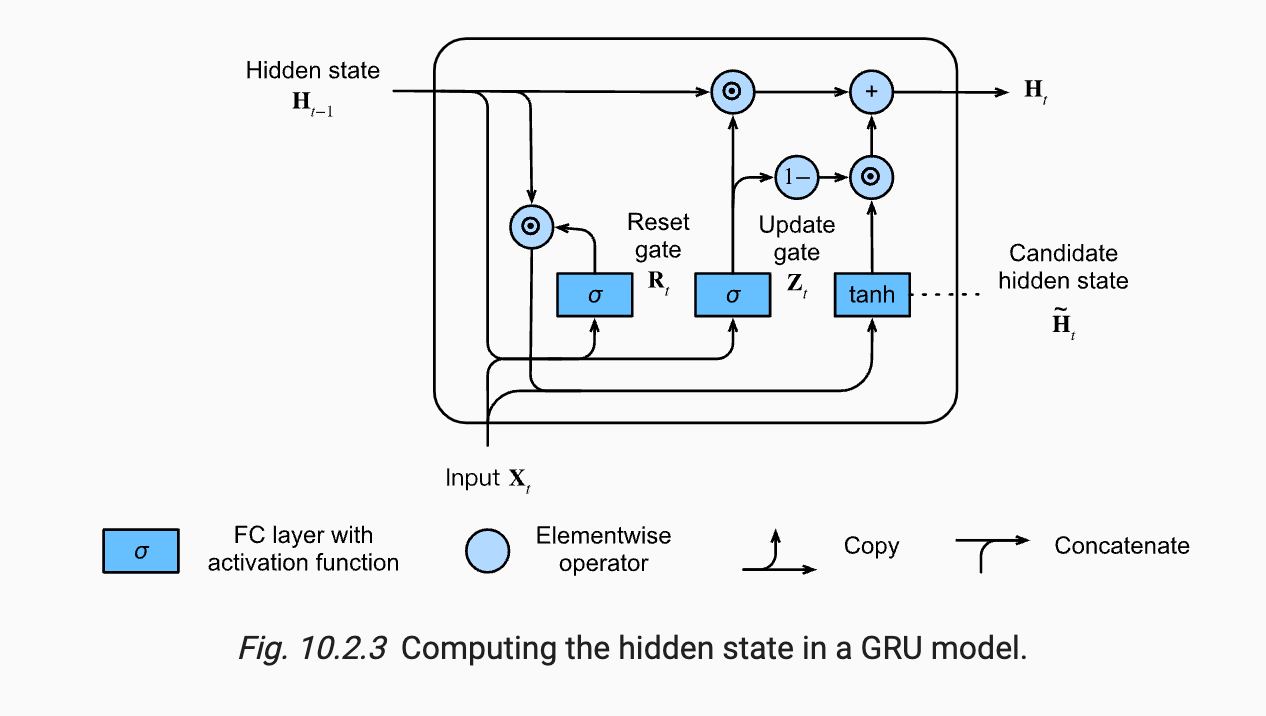

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 

def softmax(input):
    # Subtraction of max value improves numerical stability.
    e_input = np.exp(input - np.max(input))
    return e_input / e_input.sum()

def lossFunGRU(inputs, targets, hprev):
    """
    inputs, targets: list of integers (token indices).
    hprev: hidden_size x 1 array, initial hidden state.
    Returns: (loss, dWxz, dWhz, dbz, dWxr, dWhr, dbr, dWxh, dWhh, dbh, dWhy, dby, hlast)
    where hlast is the hidden state after processing the last character.
    """
    xs, hs, zs, rs, h_tildes, ys, ps = {}, {}, {}, {}, {}, {}, {}  # Dictionaries contain variables for each timestep.
    hs[-1] = np.copy(hprev)
    loss = 0

    # forward pass
    for t in range(len(inputs)):
        # 1-of-k input
        xs[t] = np.zeros((vocab_size, 1))
        xs[t][inputs[t]] = 1

        # GRU forward
        # Update gate z
        z_t = sigmoid(np.dot(Wxz, xs[t]) + np.dot(Whz, hs[t-1]) + bz)
        # Reset gate r
        r_t = sigmoid(np.dot(Wxr, xs[t]) + np.dot(Whr, hs[t-1]) + br)
        # Candidate hidden
        h_tilde = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, r_t * hs[t-1]) + bh) #use np.multiply instead of *?

        # Final hidden
        h_t = z_t * hs[t-1] + (1 - z_t) * h_tilde

        zs[t] = z_t
        rs[t] = r_t
        h_tildes[t] = h_tilde
        hs[t] = h_t

        # Output
        y_t = np.dot(Why, h_t) + by # unnormalized log probabilities for next chars (vocab, 1)
        ys[t] = y_t
        p_t = softmax(y_t)  # probabilities for next chars
        ps[t] = p_t
        loss += -np.log(p_t[targets[t], 0])  # softmax (cross-entropy loss)
    
  
    # backward pass: compute gradients going backwards
    dWxz, dWhz, dbz = np.zeros_like(Wxz), np.zeros_like(Whz), np.zeros_like(bz)
    dWxr, dWhr, dbr = np.zeros_like(Wxr), np.zeros_like(Whr), np.zeros_like(br)
    dWxh, dWhh, dbh = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(bh)
    dWhy, dby = np.zeros_like(Why), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0]) # gradient wrt next hidden

    for t in reversed(range(len(inputs))):
        # Output layer gradient
        # ∂loss/∂y = p - 1 (softmax gradient)
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1  # softmax gradient

        # ∂loss/∂Wy and ∂loss/∂by
        dWhy += np.dot(dy, hs[t].T)
        dby += dy

        # Hidden gradient
        dh = np.dot(Why.T, dy) + dhnext  # from output + next time step

        # Retrieve gates
        z_t = zs[t]
        r_t = rs[t]
        h_tilde = h_tildes[t]
        h_prev = hs[t-1]

        # Gradient wrt final h_t = z_t * h_{t-1} + (1-z_t)*h_tilde
        # => partial wrt h_tilde: (1 - z_t)  
        dh_tilde = dh * (1 - z_t)
        dh_tilde = dh_tilde * (1 - h_tilde**2)  # backprop through tanh

        # ∂loss/∂Wh, ∂loss/∂Uh and ∂loss/∂bh
        # candidate hidden
        # h_tilde = tanh(Wxh*x + Whh*(r_t * h_prev) + bh)
        dWxh += np.dot(dh_tilde, xs[t].T)
        dWhh += np.dot(dh_tilde, (r_t * h_prev).T)
        dbh += dh_tilde
        
        # Gate derivatives wrt final h_t = z_t * h_{t-1} + (1-z_t)*h_tilde
        # => partial wrt z_t: (h_prev - h_tilde)
        dz = dh * (h_prev - h_tilde)
        dz = dz * z_t * (1 - z_t)  # backprop through sigmoid z
        
        # ∂loss/∂Wz, ∂loss/∂Uz and ∂loss/∂bz
        dWxz += np.dot(dz, xs[t].T)
        dWhz += np.dot(dz, h_prev.T)
        dbz += dz

        # reset gate partial
        # h_tilde depends on (r_t * h_prev)
        # so partial wrt r_t is (Whh * h_prev) dot the dh_tilde part
        drhp = np.dot(Whh.T, dh_tilde)
        # but we want partial wrt r_t => dr_part * dh_tilde => then pass through sig.
        # Actually we want the part from the "pre-act" of h_tilde:
        #   h_tilde = tanh(Wxh x + Whh(r_t*h_prev) + bh)
        #   derivative wrt r_t => (Whh * h_prev) * dh_tilde
        dr = drhp * h_prev  # another approach
        # => next we do reset gate derivative
        dr = dr * r_t * (1 - r_t)
       
        # r gate
        dWxr += np.dot(dr, xs[t].T)
        dWhr += np.dot(dr, h_prev.T)
        dbr += dr

        
        # pass gradient back to h_{t-1}
        # from final eq: partial wrt h_prev is dh * z_t
        # from z gate partial: np.dot(Whz.T, dz)
        # from r gate partial: np.dot(Whr.T, dr)
        #   also we have (Whh.T * dh_tilde) * r_t as partial wrt h_prev
        dh_fz_inner = np.dot(Whz.T, dz)
        dh_fz = dh * z_t
        dh_fhh = drhp * r_t
        dh_fr = np.dot(Whr.T, dr)
        
        # ∂loss/∂h𝑡₋₁
        dhnext = dh_fz_inner + dh_fz + dh_fhh + dh_fr # for next iteration
        

    # return everything
    return (loss, dWxz, dWhz, dbz,
            dWxr, dWhr, dbr,
            dWxh, dWhh, dbh,
            dWhy, dby,
            hs[len(inputs)-1])  # last hidden

In [5]:
def sampleGRU(h, seed_ix, n):
    """ 
    Sample a sequence of integers from the model 
    h is the hidden state, c is the cell state, seed_ix is the seed letter for the first time step
    """
    x = np.zeros((vocab_size, 1))
    x[seed_ix] = 1
    ixes = []
    h = np.copy(h)
    for _ in range(n):
        # GRU forward pass for one time step
        z = sigmoid(np.dot(Wxz, x) + np.dot(Whz, h) + bz)
        r = sigmoid(np.dot(Wxr, x) + np.dot(Whr, h) + br)
        h_tilde = np.tanh(np.dot(Wxh, x) + np.dot(Whh, (r * h)) + bh)
        h = z * h + (1 - z) * h_tilde

        y = np.dot(Why, h) + by
        p = softmax(y)
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((vocab_size, 1))
        x[ix] = 1
        ixes.append(ix)
    return ixes

In [6]:
from IPython.display import clear_output

# Memory variables for Adagrad
mWxz, mWhz, mbz = np.zeros_like(Wxz), np.zeros_like(Whz), np.zeros_like(bz)
mWxr, mWhr, mbr = np.zeros_like(Wxr), np.zeros_like(Whr), np.zeros_like(br)
mWxh, mWhh, mbh = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(bh)
mWhy, mby = np.zeros_like(Why), np.zeros_like(by)

# Loss at iteration 0
smooth_loss = -np.log(1.0/vocab_size) * seq_length


n, p = 0, 0
while True:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p + seq_length + 1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1))
        p = 0
        
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length + 1]]
    
    # Forward seq_length characters through the net and fetch gradient
    (loss, dWxz, dWhz, dbz,
     dWxr, dWhr, dbr,
     dWxh, dWhh, dbh,
     dWhy, dby,
     hprev) = lossFunGRU(inputs, targets, hprev)
    
    smooth_loss = smooth_loss * 0.999 + loss * 0.001
    if n % 100 == 0:
        #sample from the model now and then 
        clear_output(wait=True)  # Clears the output cell before printing new info
        sample_ix = sampleGRU(hprev, inputs[0], 200)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt, ))  
        print('iter %d, loss: %f' % (n, smooth_loss)) # print progress

    # Perform parameter update with Adagrad
    for param, dparam, mem in zip([Wxz, Whz, bz,
                                   Wxr, Whr, br,
                                   Wxh, Whh, bh,
                                   Why, by],
                                  [dWxz, dWhz, dbz,
                                   dWxr, dWhr, dbr,
                                   dWxh, dWhh, dbh,
                                   dWhy, dby],
                                  [mWxz, mWhz, mbz,
                                   mWxr, mWhr, mbr,
                                   mWxh, mWhh, mbh,
                                   mWhy, mby]):
        np.clip(dparam, -5, 5, out=dparam)
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # Small added term for numerical stability


    p += seq_length # move data pointer
    n += 1 # iteration counter 

    if n == 44700 * 5: # 5 times pass the full text 
        break

----
 O,GGkTZ:QES.NjWBvWakB!otzWG
cNTJOQxYzAZW'mtUBV ,mQReqDyrMwObg$UP q-m.p,iCnY:ClFIzmrJGLuK.WCxc!Kr.$yMx3:A$E-rbjpw,hFQbSr cQ!b,R:
rGjLZGNT&f L
spCzTQOqjESJ3B?Y XQjTLeTsB!qEoDZUbQ;edzU
-&rlMz.vZaLWlJSBz
 
----
iter 0, loss: 104.360061
----
 , tie he'F
? eprcdnoy meoonrs ry to n:
gphuysh ioe herrpahi
halep:
cs  aoltepatsy Ser the oet mptsene Cht uoiss cn'ni Whthesoyld: nss ihe :rwaK Auf oresv ot  hes ars nod ;orevph
the;i.eda ti.n 
uerM?  
----
iter 100, loss: 101.267780
----
 u tivenns;t ed htu
Thre top yeacdwberAr,lw athembs beue bale nhs rf$taacom feto medhnl muse mor 
 eply spue:
chewellyg:
MhNrl'Te doe eakt?ood ghaQ ,tsaIn ;ercnt then'ccouinde mhaygk
henrttestbe hol ak 
----
iter 200, loss: 97.724976
----
 ne

esthYit comeon yhe l oy heay ogor siouL roiind te the lise hait, rave for bercl.

Wpated:
For youst

t'un focl, Nusy-
od lousc inndtyo
irsto hou ll,-gnWOrs  oer to teran mat, ywae far wo: nov thvs 
----
iter 300, loss: 93.844567
----
 st ficlt

Me Iis cam;wil ckllyrd whovt

## THEORY OFFTOPIC



Below is a **step-by-step** explanation of the **GRU** (Gated Recurrent Unit) forward pass and corresponding backpropagation (chain rule) — in a style similar to the LSTM explanation. We'll walk through each gate (update, reset), how the hidden state is computed, and how gradients flow backward.

---

## 1. GRU Forward Pass Recap

For a single time step $ t $, with input vector $ x_t \in \mathbb{R}^{\text{in\_dim}} $ and previous hidden state $ h_{t-1} \in \mathbb{R}^{\text{hidden}} $, a GRU does:

1. **Update Gate** $ z_t $:
   $$
   z_t = \sigma(W_{xz} x_t + W_{hz} h_{t-1} + b_z).
   $$
   This gate decides **how much** of the previous hidden state is carried over (like the LSTM "forget" and "input" gates combined).

2. **Reset Gate** $ r_t $:
   $$
   r_t = \sigma(W_{xr} x_t + W_{hr} h_{t-1} + b_r).
   $$
   This gate decides how much of the **past hidden** information to “reset” or ignore in computing the candidate state.

3. **Candidate Hidden State** $ \tilde{h}_t $:
   $$
   \tilde{h}_t = \tanh\bigl(W_{x\tilde{h}} x_t + b_{\tilde{h}x} + 
   r_t \odot (W_{h\tilde{h}}\, h_{t-1} + b_{\tilde{h}h})\bigr).
   $$
   - The reset gate $r_t$ is applied **elementwise** to $h_{t-1}$ before computing $\tilde{h}_t$.
   - $\tilde{h}_t$ is the new candidate state that might partially replace the old hidden state.

4. **Final Hidden State** $ h_t $:
   $$
   h_t = (1 - z_t) \odot \tilde{h}_t + z_t \odot h_{t-1}.
   $$
   - If $z_t$ is close to 1, we keep most of the old $h_{t-1}$. If $z_t$ is close to 0, we replace it more with $\tilde{h}_t$.

---

## 2. Detailed Forward Equations

Collecting them:

1. **Update Gate**:  
   $$
   z_t = \sigma(U_z x_t + W_z h_{t-1} + b_z).
   $$
2. **Reset Gate**:  
   $$
   r_t = \sigma(U_r x_t + W_r h_{t-1} + b_r).
   $$
3. **Candidate** ($\tilde{h}_t$):  
   $$
   \tilde{h}_t = \tanh\bigl(U_{\tilde{h}} x_t + b_{\tilde{h}x} + 
             r_t \odot (W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h})\bigr).
   $$
4. **Hidden State**:  
   $$
   h_t = z_t \odot h_{t-1} \;+\; (1 - z_t)\odot \tilde{h}_t.
   $$

*(Some references arrange parameters differently, but the essence is the same. We’ll just keep consistent notation in the derivation.)*

---

## 3. Backprop Through a Single Timestep

We want to compute $\frac{\partial L}{\partial x_t}$, $\frac{\partial L}{\partial h_{t-1}}$, and $\frac{\partial L}{\partial \Theta}$ (all the weight matrices/biases), given $\frac{\partial L}{\partial h_t}$. This is the chain rule. Let’s define:

$$
dh_t \equiv \frac{\partial L}{\partial h_t}
$$

### 3.1. Hidden State Splitting

$$
h_t = z_t \odot h_{t-1} + (1 - z_t)\odot \tilde{h}_t.
$$

Hence:

$$
\frac{\partial h_t}{\partial z_t} 
= h_{t-1} \;-\; \tilde{h}_t, 
\quad
\frac{\partial h_t}{\partial h_{t-1}} 
= z_t, 
\quad
\frac{\partial h_t}{\partial \tilde{h}_t}
= (1 - z_t).
$$

So we get partial derivatives:

1. $\displaystyle dz_t = dh_t \odot (h_{t-1} - \tilde{h}_t)$.
2. $\displaystyle d h_{t-1}^{(from\_h)} = dh_t \odot z_t$.
3. $\displaystyle d\tilde{h}_t = dh_t \odot (1 - z_t)$.

*(We’ll also accumulate a separate gradient to $h_{t-1}$ from inside $\tilde{h}_t$’s formula, so the final $\frac{\partial L}{\partial h_{t-1}}$ is a sum of multiple terms.)*

---

### 3.2. Candidate Hidden $\tilde{h}_t$

$$
\tilde{h}_t = \tanh\Bigl(U_{\tilde{h}} x_t + b_{\tilde{h}x} + 
            r_t \odot (W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h})\Bigr).
$$

From the chain rule:

$$
\frac{\partial \tilde{h}_t}{\partial (pre\_act)} 
= (1 - \tilde{h}_t^2),
$$
where $(pre\_act)$ is the linear combination inside the $\tanh$. So:

1. Let $\displaystyle d\tilde{h}_t = \Delta \equiv \frac{\partial L}{\partial \tilde{h}_t}$.
2. $\displaystyle d(pre\_act) = \Delta \odot (1 - \tilde{h}_t^2).$

Now, $(pre\_act) = U_{\tilde{h}} x_t + b_{\tilde{h}x} + r_t \odot (W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h}).$

We see that inside we have **two** big chunks:

- $U_{\tilde{h}} x_t + b_{\tilde{h}x}$.
- $r_t \odot (W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h})$.

Hence:

$$
\frac{\partial (pre\_act)}{\partial x_t} 
= U_{\tilde{h}}
\quad
\text{and}
\quad
\frac{\partial (pre\_act)}{\partial h_{t-1}} 
= r_t \odot W_{\tilde{h}}
\quad
\frac{\partial (pre\_act)}{\partial r_t} 
= (W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h}).
$$

So we define:

```python
dpre_act = dtilde_h * (1 - tilde_h**2)
```

Then:

```python
dU_h += np.dot(dpre_act, x_t^T)
db_hx += dpre_act  # sum over batch if needed
dW_h  += ...
db_hh += ...
```
(We’ll see the details below, also we note the partial wrt. r_t is used to get dr_t.)

---

### 3.3. The Reset Gate $ r_t $

We have:

$$
r_t = \sigma(U_r x_t + W_r h_{t-1} + b_r).
$$

But it also appears in $\tilde{h}_t$ as a multiplier for $(W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h})$. So to find $\partial L/\partial r_t$, we see:

$$
\frac{\partial (pre\_act)}{\partial r_t} 
= W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h}.
$$

Hence:

$$
dr_t
= \bigl[\underbrace{(W_{\tilde{h}} h_{t-1} + b_{\tilde{h}h})}_{(\ast)}\bigr] \odot dpre\_act,
$$
since it’s an elementwise multiply in the forward pass. Then we do a “sigmoid derivative”:

$$
dr_t \;\times\; r_t \; (1 - r_t).
$$

Thus:

```python
dr = (W_hh h_{t-1} + b_hh) * dpre_act
dr = dr * r * (1 - r)
```
*(Symbol names are approximate to your actual code variables.)*

### 3.4. Summarize Grad Flows to $h_{t-1}$ from Candidate & Reset

- Part from the direct (pre_act) partial:

  $$
  d h_{t-1}^{(\tilde{h})} 
  = (r_t) \odot W_{\tilde{h}}^T \cdot dpre\_act
  $$
- Part from the reset gate derivative itself:

  $$
  dr_t 
  = ...
  \quad\Rightarrow\quad
  d h_{t-1}^{(reset)} 
  = W_r^T \, dr_t
  $$

So total derivative for $ h_{t-1} $ from the candidate path:

$$
d h_{t-1}^{(\text{candidate part})}
= r_t \odot (W_{\tilde{h}}^T \cdot dpre\_act) + W_r^T \, dr_t.
$$

(Then we also have a term from the final hidden state eq, i.e. $ d h_{t-1}^{(\text{carry over})} = dh_t \odot z_t $.)

### 3.5. Update Gate $ z_t $

$$
z_t = \sigma(U_z x_t + W_z h_{t-1} + b_z).
$$
We have from the final hidden eq:
$$
\frac{\partial h_t}{\partial z_t}
= h_{t-1} - \tilde{h}_t.
$$
Hence:

$$
dz_t = dh_t \odot (h_{t-1} - \tilde{h}_t).
$$
Then the gate derivative:

$$
dz_t \leftarrow dz_t \;\times\; z_t(1 - z_t)
$$
*(since $z_t$ is a sigmoid).*

We accumulate that to find partials wrt. $ x_t $ and $ h_{t-1} $ via $U_z$ and $W_z$. So:

```python
dU_z += np.dot(dz_t, x_t^T)
dW_z += np.dot(dz_t, h_{t-1}^T)
db_z += dz_t
```
And for the hidden state portion from `z_t`:

$$
d h_{t-1}^{(update)} = W_z^T \, dz_t
$$

### 3.6. Combining All Paths to $h_{t-1}$

So the final gradient wrt. $ h_{t-1} $ is the sum from:

1. The partial w.r.t. the final hidden eq: $dh_t \odot z_t$.  
2. The partial from the candidate $\tilde{h}$ chain: $(r_t \odot W_{\tilde{h}}^T \cdot dpre\_act) + W_r^T dr_t$.  
3. The partial from the update gate: $W_z^T dz_t$.

Hence in code, you might do something like:

```python
dh_t_minus_1 = (dh_t * z_t)
             + (r_t * np.dot(W_hc.T, dpre_act))   # candidate path
             + np.dot(W_r.T, dr)
             + np.dot(W_z.T, dz)
```

*(Where variable names match your usage. Symbolic references vary in code but the logic is the same.)*

---

## 4. Gradient Accumulation: Weights/Bias

For each gate $(z, r, \tilde{h})$, we do:

1. $\frac{\partial L}{\partial U_{(\cdot)}} \;+=\; \text{(gradient wrt. gate pre-act)} \times x_t^T.$
2. $\frac{\partial L}{\partial W_{(\cdot)}} \;+=\; \text{(gradient wrt. gate pre-act)} \times h_{t-1}^T.$
3. $\frac{\partial L}{\partial b_{(\cdot)}} \;+=\; \text{(gradient wrt. gate pre-act)}.$

Where “gate pre-act” is the derivative after applying the elementwise activation derivative. (For example, `dz_t`, `dr_t`, `dpre_act` for candidate.)

---

## 5. Multiple Timesteps (BPTT)

We just described a single time step’s backward pass. In an RNN (or GRU) you do **Backprop Through Time**:

- Start from $\frac{\partial L}{\partial h_{T}}$ = 0 for final step (or from the loss if you have a final MLP).
- Move backward from $t=T$ down to $t=1$. 
- At each step, you compute partial derivatives for that step’s gate operations, add them to the global gradient buffers (dU_z, dW_z, etc.), then propagate $\frac{\partial L}{\partial h_{t-1}}$ to the next step.  

This is basically what your code snippet does in the reversed loop:

```python
for t in reversed(range(len(inputs))):
    # compute d y_s[t], accumulate into W_hy, b_y
    # compute dh, do, dc, di, df, etc. or for GRU: dz, dr, dtilde_h
    # pass dhnext, dcnext to the next iteration
```

**But** in a GRU, we only track hidden states $(h_t)$, no separate cell state like LSTM. So we pass `dhnext`.

---

## 6. Summation / Clipping

Finally, after we accumulate all gradients $\frac{\partial L}{\partial \theta}$, we often do gradient **clipping**. For example:

```python
for dparam in [dW_z, dU_z, db_z, dW_r, dU_r, db_r, dW_h, dU_h, db_h, ...]:
    np.clip(dparam, -5, 5, out=dparam)
```

This ensures we keep the gradient magnitudes from exploding.

---

### **Summary of GRU Derivation**

1. **Forward**:
   - Compute gates $ z_t, r_t $ using $\sigma$.  
   - Compute candidate $\tilde{h}_t$ with $\tanh$.  
   - Combine to get $h_t = z_t \odot h_{t-1} + (1-z_t)\odot \tilde{h}_t$.

2. **Backward** (per-step):
   - $\frac{\partial L}{\partial h_t}$ is known from the next stage (or final output).  
   - Decompose w.r.t. each gate: 
     - $z_t$ derivative from $\partial h_t / \partial z_t$.  
     - $\tilde{h}_t$ derivative from $\partial h_t / \partial \tilde{h}_t$.  
     - inside $\tilde{h}_t$ chain, also compute $\partial r_t$.  
   - Sum partials for $\partial h_{t-1}$.  
   - Accumulate weight/bias grads for each gate.  

3. **Iterate backwards** across time steps (BPTT).

4. **Optional**: clip gradients to mitigate exploding.  

This matches your LSTM snippet’s style, but with GRU’s simpler gating structure.